Load required Python libraries

In [2]:
import os
from langchain_chroma import Chroma
from chromadb.config import Settings as ChromaSettings
from langchain_community import embeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_ollama import OllamaLLM
from langchain.chains.question_answering import load_qa_chain
from langchain_core.documents import Document
import time
import pandas as pd
import re

Load ollama embeddings 

In [3]:
EMBEDDINGS = embeddings.OllamaEmbeddings(model="nomic-embed-text:latest", num_gpu=8)

PERSIST_DIR = "./chroma_langchain"

C:\Users\HP\AppData\Local\Temp\ipykernel_2916\488189547.py:1: LangChainDeprecationWarning:

The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.



In [4]:
def create_vector_store(chunks):
    documents = [Document(page_content=chunk, metadata={}) for chunk in chunks]
    v_db = Chroma.from_documents(
        documents=documents,
        embedding=EMBEDDINGS,          
        persist_directory=PERSIST_DIR
    )
    return v_db

def load_vector_store():
    return Chroma(
    persist_directory=PERSIST_DIR,
    embedding_function=EMBEDDINGS, 
)
    
def generate_response(vector_store, query, k=4):
    llm = OllamaLLM(model="qwen2.5:latest")  
    chain = load_qa_chain(llm, chain_type="stuff", verbose=False)

    matching_docs = vector_store.similarity_search(query, k=k)
    response = chain.invoke({
        "input_documents": matching_docs,
        "question": query
    })
    return response

Load data and create chunks

In [6]:
# Load CSV file with the correct encoding
df = pd.read_csv("epo_decisions.csv", encoding='ISO-8859-1')

# replace 'None' string with actual None (NaN) for proper handling
df['ep-catchword-language'] = df['ep-catchword-language'].replace('None', None)
df['ep-headnote-language'] = df['ep-headnote-language'].replace('None', None)

# merge the columns, taking the non-None value
df["Language"] = df['ep-catchword-language'].combine_first(df['ep-headnote-language'])
df["Decision Type"] =  df["Case Code"]

# function to create case 
def generate_case_number(reference):
    match = re.match(r'([GJTDW])(\d{2})(\d{4})[A-Z]+\d+', reference)
    if match:
        decision_type = match.group(1)
        case_number = match.group(3).lstrip("0")  # remove zeros
        year = match.group(2)
        return f"{decision_type} {case_number}/{year}"
    return reference  # keep original in case of no match

df["Case Number"] = df["Reference"].apply(generate_case_number)

# remove duplicates
df = df.drop_duplicates(subset=["ep-headnote", "ep-catchword"], keep="first")

# number of extracted decisions
extrahiert = len(df)

# Filter: only G decisions in EN
df_g_en = df[(df["Language"] == "EN") & (df["Case Code"] == "G")]

# print(len(df_g_en))  # number of decisions
# 120; correct
#print(df_g_en.head(20))

chunks = []

for _, row in df_g_en.iterrows():
    # Headnote, otherwise Catchword
    text = row["ep-headnote"] if pd.notna(row["ep-headnote"]) else row["ep-catchword"]
    
    # if Catchword is NaN → skip
    if pd.isna(text):
        continue
    
    # format string
    entry = f'{row["Case Number"]} ({row["Reference"]}) {text}'
    chunks.append(entry)

file_path = "chunks.txt"

# write all chunks in one TXT
with open(file_path, "w", encoding="utf-8") as f:
    for chunk in chunks:
        f.write(chunk + "\n")

print(f"{len(chunks)} Chunks saved in {file_path}.")


120 Chunks saved in chunks.txt.


Create vector store (did not work at first run, excecute twice)

In [7]:
# Create vector store
vector_store = create_vector_store(chunks)

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


Ask questions

In [8]:
vector_store_loaded = load_vector_store()
query = "Can a European patent application be refused if it claims the same subject-matter as a European patent which has been granted to the same applicant? (cite a relevant decision, in form of GXX/XX)"
# G4/19

answer = generate_response(vector_store_loaded, query)
print(answer['output_text'])

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
C:\Users\HP\AppData\Local\Temp\ipykernel_2916\2265326480.py:18: LangChainDeprecationWarning:

This class is deprecated. See the following migration guides for replacements based on `chain_type`:
stuff: https://python.langchain.com/docs/versions/migrating_chains/stuff_docs_chain
map_reduce: https://python.langchain.com/docs/versions/migrating_chains/map_reduce_chain
refine: https://python.langchain.com/docs/versions/migrating_chains/refine_chain
map_rerank: https://python.langchain.com/docs/versions/migrating_chains/map_rerank_docs_chain

See also guides on retrieval and question-answering here: https://python.langchain.com/docs/how_to/#qa-with-rag

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


Yes, a European patent application can be refused under Articles 97(2) and 125 EPC if it claims the same subject-matter as a European patent which has been granted to the same applicant and does not form part of the state of the art pursuant to Article 54(2) and (3) EPC. This is according to the decision G 4/19 (G190004EX1).


# Visualization of the vector store

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event CollectionGetEvent: capture() takes 1 positional argument but 3 were given


240


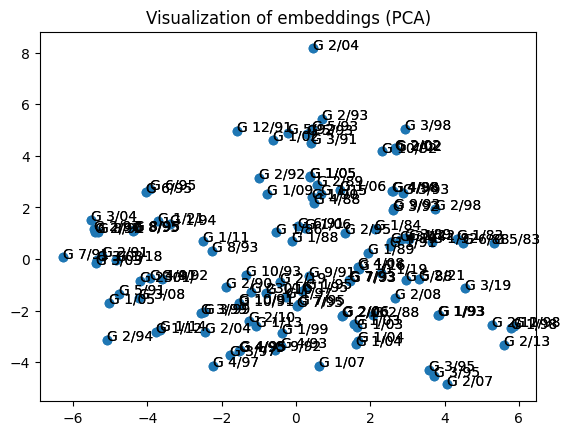

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

vector_store_loaded = load_vector_store()

# load vectore
data = vector_store_loaded.get(include=["embeddings", "documents"])
embeddings = data["embeddings"]
docs = data["documents"]

# 2D reduction via PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# plotting
#plt.figure(figsize=(10, 7))
plt.scatter(reduced[:, 0], reduced[:, 1])

print(len(docs))
# Optional: Dokumentausschnitte als Labels anzeigen
for i, txt in enumerate(docs):
#for i, txt in enumerate(docs[:50]):  # not too many at once
    plt.annotate(txt[:7], (reduced[i, 0], reduced[i, 1]))  # Kür

plt.title("Visualization of embeddings (PCA)")
plt.savefig("embedding_plot.png", dpi=300, bbox_inches='tight') 

plt.show()


In [10]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype"  # ideal für JupyterLab 3+
# Alternativen, falls nötig: "notebook_connected" oder "iframe"

Failed to send telemetry event CollectionGetEvent: capture() takes 1 positional argument but 3 were given


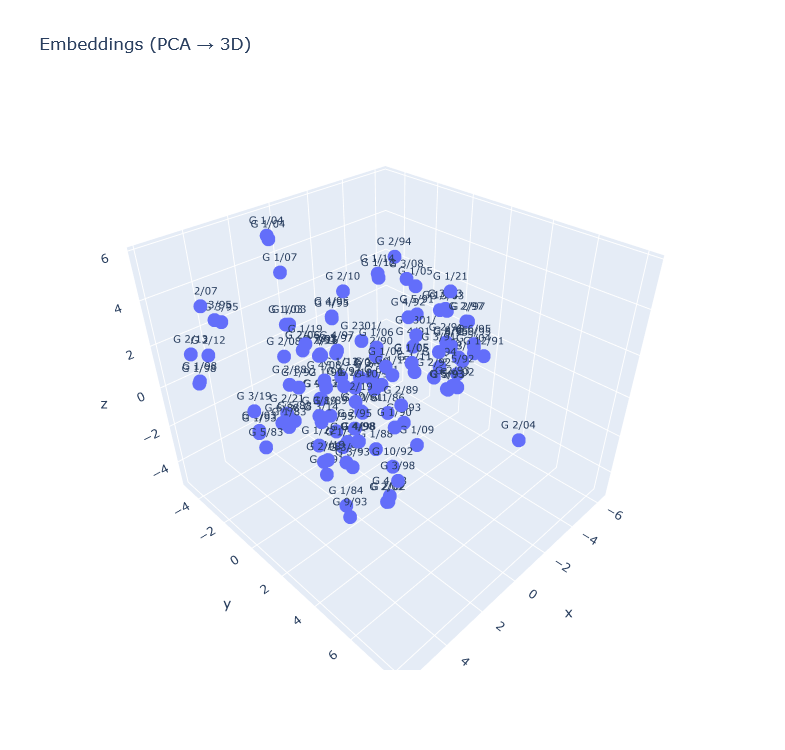

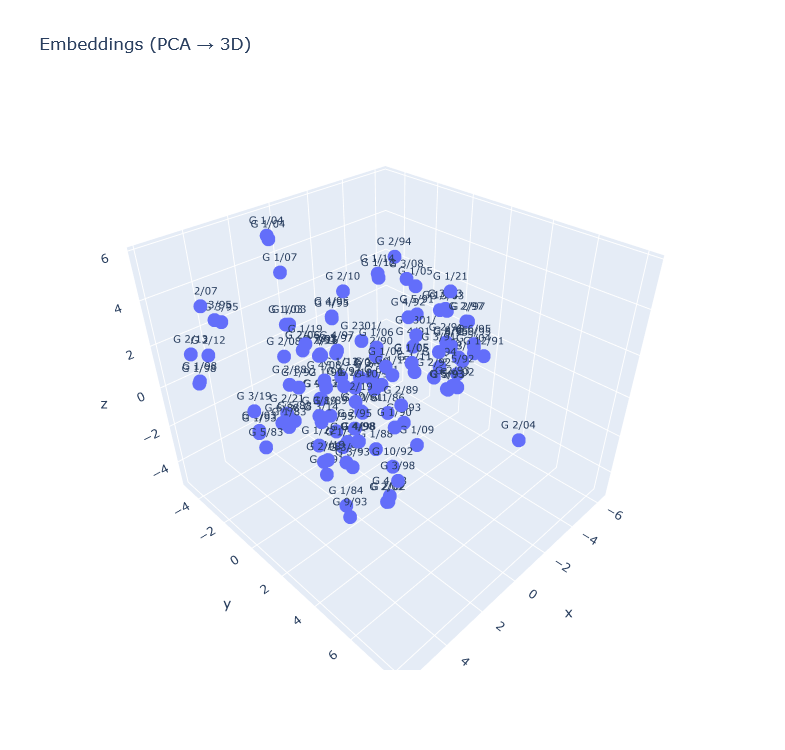

Punkte: 240 Embeddings-Shape: (240, 768)


In [11]:
import numpy as np, pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px, plotly.graph_objects as go
import plotly.io as pio
from IPython.display import display

pio.renderers.default = "plotly_mimetype"   # oder "notebook_connected"

vs = vector_store_loaded

# Daten holen (ohne 'ids' in include!)
n = vs._collection.count()
data = vs._collection.get(include=["embeddings","documents","metadatas"], limit=n)

embeddings = np.asarray(data["embeddings"], dtype=float)
ids   = data.get("ids") or [str(i) for i in range(len(embeddings))]
docs  = data.get("documents") or [""] * len(embeddings)
metas = data.get("metadatas") or [{}] * len(embeddings)

# Robustheit
mask = np.isfinite(embeddings).all(axis=1)
embeddings = embeddings[mask]
ids   = [i for i, m in zip(ids, mask) if m]
docs  = [d for d, m in zip(docs, mask) if m]
metas = [m for m, msk in zip(metas, mask) if msk]

# PCA → 3D
pca = PCA(n_components=3, random_state=42)
reduced = pca.fit_transform(embeddings)

df = pd.DataFrame(metas)
df.insert(0, "id", ids)
# Volltext-Snippet (für Hover)
df["text"] = [(d or "").replace("\n"," ")[:200] for d in docs]
# NEU: Label (erste 7 Zeichen der Docs, bereinigt)
df["label7"] = [((d or "").replace("\n"," ").strip())[:7] or "…" for d in docs]

df["x"], df["y"], df["z"] = reduced[:,0], reduced[:,1], reduced[:,2]

color_by = "source" if "source" in df.columns else None

fig = px.scatter_3d(
    df, x="x", y="y", z="z",
    color=color_by,
    hover_data=["id","text"] + ([color_by] if color_by else []),
    height=750,
    title="Embeddings (PCA → 3D)"
)

# Labels nur für wenige Punkte (z. B. die ersten 40)
#label_n = min(40, len(df))
lab = df
fig.add_trace(go.Scatter3d(
    x=lab["x"], y=lab["y"], z=lab["z"],
    mode="text",                 # "markers+text" für Punkte + Text
    text=lab["label7"],          # <- hier kommen die 7-Zeichen-Labels hin
    showlegend=False,
    textfont=dict(size=10)
))

# Anzeige erzwingen
display(fig)
fig.show()

# Fallback: als HTML speichern (öffnet Browser)
fig.write_html("embedding_plot_3d.html", include_plotlyjs="inline", auto_open=True)

print("Punkte:", len(df), "Embeddings-Shape:", embeddings.shape)


Convert vector store to TSV

In [12]:
import csv
from langchain_chroma import Chroma
from langchain_community.embeddings import OllamaEmbeddings
from chromadb.config import Settings

PERSIST_DIR = "./chroma_langchain"
EMBED_MODEL = "nomic-embed-text"

def export_to_tsv(persist_dir, embed_model, out_file="vector_store.tsv"):
    # Embeddings initialisieren (wichtig: gleiches Modell wie beim Indexieren)
    embeddings = OllamaEmbeddings(model=embed_model)

    client_settings = Settings(anonymized_telemetry=False)
    vs = Chroma(
        persist_directory=persist_dir,
        embedding_function=embeddings,
    )

    # Alle Einträge holen
    results = vs._collection.get(include=["embeddings", "metadatas", "documents"])

    with open(out_file, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f, delimiter="\t")
        # Header
        writer.writerow(["id", "text", "embedding", "metadata"])
        for _id, doc, emb, meta in zip(
            results["ids"], results["documents"], results["embeddings"], results["metadatas"]
        ):
            writer.writerow([
                _id,
                doc.replace("\n", " ") if doc else "",
                " ".join(map(str, emb)) if emb is not None else "",
                str(meta) if meta else "{}"
            ])
    print(f"[OK] Exportiert nach {out_file}")

if __name__ == "__main__":
    export_to_tsv(PERSIST_DIR, EMBED_MODEL)


Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


[OK] Exportiert nach vector_store.tsv


In [14]:
import os
os.environ.setdefault("CHROMA_TELEMETRY_DISABLED", "1")  # optional: Telemetrie aus

from langchain_chroma import Chroma
from chromadb.config import Settings



vs = Chroma(persist_directory=PERSIST_DIR)

count = vs._collection.count()
e = vs._collection.get(include=["embeddings","metadatas","documents"], limit=1)
dim = len(e["embeddings"][0])                    # Embedding-Dimension
space = (vs._collection.metadata or {}).get("hnsw:space", "unbekannt")  # Distanzmetrik

print("Anzahl:", count)
print("Dimension:", dim)
print("Distanzmetrik:", space)
print("Beispiel-IDs:", e["ids"])
print("Beispiel-Metadaten:", e["metadatas"])
print("Beispiel-Text:", (e["documents"][0][:200] + "…") if e["documents"] else "")
,

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


Anzahl: 240
Dimension: 768
Distanzmetrik: unbekannt
Beispiel-IDs: ['28c06547-c126-4193-96c9-8cb78f55b8fb']
Beispiel-Metadaten: [None]
Beispiel-Text: G 1/02 (G020001EP1) [EN] Points 4 and 6 of the Notice from the Vice-President Directorate-General 2 dated 28 April 1999 (OJ EPO 1999, 506) do not conflict with provisions of a higher level.…


''